In [16]:
import torch
from torch import nn
import numpy as np

In [17]:
def Omega(n_i, n_w):
    return np.floor(127 / ((2**n_i - 1)*(2**n_w - 1)))

Omega(4,3)

1.0

In [18]:
class FCIris(torch.nn.Module):
    """Neural network for Iris classification

    We define a fully connected network with three (3) fully connected (fc) layers that
    perform feature extraction and one (fc) layer to produce the final classification.
    We will use 3 neurons on all layers to ensure that the FHE accumulators
    do not overflow (we are currently only allowed a maximum of 7 bits-width).
    More information on this is available at 
    https://docs.zama.ai/concrete-numpy/main/user/howto/reduce_needed_precision.html#limitations-for-fhe-friendly-neural-network.

    Due to accumulator limits, we have to design a network with only a few neurons on each layer.
    This is in contrast to a traditional approach where the number of neurons increases after
    each layer or block.
    """

    def __init__(self, input_size):
        super().__init__()

        # The first layer processes the input data, in our case 4 dimensional vectors
        self.linear1 = nn.Linear(input_size, 3)
        self.sigmoid1 = nn.Sigmoid()
        # Next, we add a one intermediate layer
        self.linear2 = nn.Linear(3, 3)
        self.sigmoid2 = nn.Sigmoid()
        # Finally, we add the decision layer for 3 output classes encoded as one-hot vectors
        self.decision = nn.Linear(3, 3)

    def forward(self, x):

        x = self.linear1(x)
        x = self.sigmoid1(x)
        x = self.linear2(x)
        x = self.sigmoid2(x)
        x = self.decision(x)

        return x


In [19]:
# Get iris dataset
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
print(type(X))
print(X.shape)

# Split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Convert to tensors
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

print(y_train[0])

print(f"X.shape[1] = {X.shape[1]}")
print(f"X_train: {X_train.shape}")
print(f"{X_train[0]}")
print(f"min: {min([min(X) for X in X_train]):.2f}, max: {max([max(X) for X in X_train]):.2f}")
print(X_train[0][:16])

Xmin = min([min(X) for X in X_train])
Xmax = max([max(X) for X in X_train])

perm = torch.randperm(X_train.size()[0])
print(X_train[perm][:8])
print(y_train[perm][:8])

# Initialize our model
model = FCIris(X.shape[1])

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Define the number of iterations
n_iters = 50001
print(f"n_iters = {n_iters}")

# Define the batch size
batch_size = 16

<class 'numpy.ndarray'>
(150, 4)
tensor(0)
X.shape[1] = 4
X_train: torch.Size([112, 4])
tensor([5.0000, 3.6000, 1.4000, 0.2000])
min: 0.10, max: 7.70
tensor([5.0000, 3.6000, 1.4000, 0.2000])
tensor([[6.7000, 3.3000, 5.7000, 2.5000],
        [6.2000, 2.8000, 4.8000, 1.8000],
        [5.5000, 2.5000, 4.0000, 1.3000],
        [7.7000, 3.8000, 6.7000, 2.2000],
        [5.5000, 2.4000, 3.8000, 1.1000],
        [4.6000, 3.1000, 1.5000, 0.2000],
        [5.1000, 3.5000, 1.4000, 0.3000],
        [6.0000, 2.2000, 4.0000, 1.0000]])
tensor([2, 2, 1, 2, 1, 0, 0, 1])
n_iters = 50001


In [20]:
def train():
    for iter in range(n_iters):
        # Get a random batch of training data
        idx = torch.randperm(X_train.size()[0])
        X_batch = X_train[idx][:batch_size]
        y_batch = y_train[idx][:batch_size]

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = criterion(y_pred, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()


        if iter % 5000 == 0:
            # Print epoch number, loss and accuracy
            accuracy = torch.sum(torch.argmax(y_pred, dim=1) == y_batch).item() / y_batch.size()[0]
            print(f'Iterations: {iter:02} | Loss: {loss.item():.4f} | Accuracy: {100*accuracy:.2f}%')
            if accuracy == 1:
                break

In [21]:
from concrete.torch.compile import compile_torch_model
print("Training a FHE friendly quantized network.")
for trial in range(10):
    try:
        train()
        print("Compiling the model to FHE.")
        quantized_compiled_module = compile_torch_model(
            model,
            X_train,
            n_bits=3,
        )
        print("The network is trained and FHE friendly.")
        break
    except Exception as e:
        if str(e).startswith("max_bit_width of some nodes is too high"):
            print(f'The network is not fully FHE friendly, retrain.')
            # train()
        else:
            raise e
            break

Training a FHE friendly quantized network.
Iterations: 00 | Loss: 1.1603 | Accuracy: 25.00%
Iterations: 5000 | Loss: 0.0395 | Accuracy: 100.00%
Compiling the model to FHE.
The network is trained and FHE friendly.


In [37]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[ 0.0138, -1.3505,  1.4171,  0.9709],
        [ 1.6605,  2.1147, -2.7720, -2.7943],
        [ 0.5624,  1.6264, -1.4028, -1.8363]], requires_grad=True)
Parameter containing:
tensor([-0.5832,  1.5223,  0.5549], requires_grad=True)
Parameter containing:
tensor([[-1.7645,  4.5289,  3.2209],
        [-1.0942,  0.6569,  0.6558],
        [ 3.7114, -1.8852, -3.3088]], requires_grad=True)
Parameter containing:
tensor([-0.9660,  0.2008,  2.3407], requires_grad=True)
Parameter containing:
tensor([[ 2.9192,  1.5321, -7.6858],
        [ 2.4713, -0.3679,  1.5519],
        [-5.9878, -0.7415,  4.9918]], requires_grad=True)
Parameter containing:
tensor([ 1.5060, -1.1462, -0.3444], requires_grad=True)


In [36]:
X = torch.tensor(np.random.uniform(Xmin,Xmax,4)).float()

print(model(X))

print(quantized_compiled_module(X.numpy()))

he_pred = quantized_compiled_module.forward_fhe.run(np.array([X.numpy()]).astype(np.uint8))
print(he_pred)

homomorphic_predictions = quantized_compiled_module.dequantize_output(
    np.array(he_pred, dtype=np.float32).reshape((1,3))
)

print(homomorphic_predictions)

tensor([-5.5217,  0.4520,  4.0320], grad_fn=<AddBackward0>)
[[10 37 58]]
[[10 37 58]]
[[-4.70196   0.587745  4.70196 ]]


In [29]:
y_pred = model(X_test)

In [30]:
# We now have a module in full numpy.
# Convert data to a numpy array.
X_train_numpy = X_train.numpy()
X_test_numpy = X_test.numpy()
y_train_numpy = y_train.numpy()
y_test_numpy = y_test.numpy()

# quant_model_predictions = quantized_compiled_module(X_test_numpy)


print(X_test_numpy[0])
xt = np.array(X_test_numpy[0]).astype(np.uint8)
print(xt)

print(y_pred)
print(y_pred.argmax(1))

[6.1 2.8 4.7 1.2]
[6 2 4 1]
tensor([[-2.9454,  4.2058, -1.8531],
        [ 5.9930, -0.8440, -6.1121],
        [-6.9154,  1.1713,  5.1203],
        [-3.1767,  4.3188, -1.7303],
        [-2.9040,  4.1839, -1.8734],
        [ 5.9588, -0.8215, -6.1003],
        [-2.3149,  3.8796, -2.1846],
        [-6.4291,  1.6382,  4.1734],
        [-4.8832,  3.0410,  1.2458],
        [-2.4466,  3.9520, -2.1190],
        [-5.6242,  2.4248,  2.5916],
        [ 5.9281, -0.8013, -6.0896],
        [ 6.0157, -0.8590, -6.1198],
        [ 5.9249, -0.7992, -6.0885],
        [ 6.0072, -0.8533, -6.1170],
        [-3.0420,  4.2815, -1.8333],
        [-6.8921,  1.1927,  5.0760],
        [-2.5126,  3.9867, -2.0845],
        [-3.1580,  4.3004, -1.7302],
        [-6.8874,  1.1970,  5.0671],
        [ 5.8906, -0.7768, -6.0765],
        [-5.3639,  2.6693,  2.0902],
        [ 5.9188, -0.7952, -6.0864],
        [-6.8517,  1.2296,  4.9993],
        [-5.8016,  2.2335,  2.9587],
        [-6.7453,  1.3313,  4.7926],
        [-

In [31]:
from tqdm import tqdm
homomorphic_quant_predictions = []
for x_q in tqdm(X_test_numpy):
    homomorphic_quant_predictions.append(
        quantized_compiled_module.forward_fhe.run(np.array([x_q]).astype(np.uint8))
    )
    
homomorphic_predictions = quantized_compiled_module.dequantize_output(
    np.array(homomorphic_quant_predictions, dtype=np.float32).reshape(quant_model_predictions.shape)
)

100%|██████████| 38/38 [05:04<00:00,  8.02s/it]


NameError: name 'quant_model_predictions' is not defined

In [ ]:
print(f'Test Accuracy: {100*(y_pred.argmax(1) == y_test).float().mean():.2f}%')
print(f'Test Accuracy Quantized Inference: {100*(quant_model_predictions.argmax(1) == y_test_numpy).mean():.2f}%')
print(f'Test Accuracy Homomorphic Inference: {100*(homomorphic_predictions.argmax(1) == y_test_numpy).mean():.2f}%')

<Figure size 432x288 with 0 Axes>

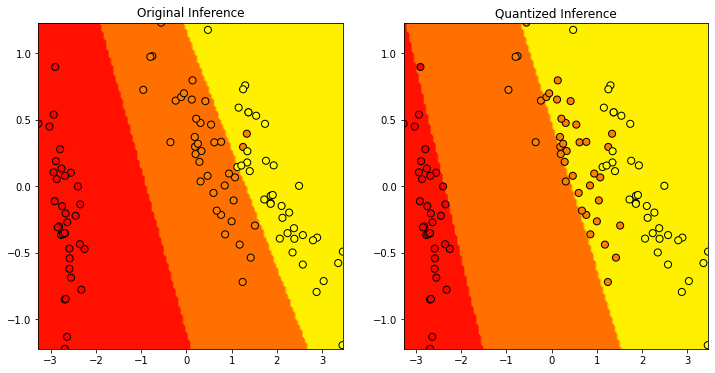

In [35]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_numpy)

b_min = np.min(X_train_2d, axis=0)
b_max = np.max(X_train_2d, axis=0)

grid_dims = tuple([np.linspace(b_min[i], b_max[i], 128) for i in range(X_train_2d.shape[1])])
ndgrid_tuple = np.meshgrid(*grid_dims)
grid_2d = np.vstack([g.ravel() for g in ndgrid_tuple]).transpose()

grid_test = pca.inverse_transform(grid_2d)

grid_pred_all = quantized_compiled_module(grid_test)
grid_pred_all_original = model(torch.tensor(grid_test).float()).detach().numpy()

pred_classes = np.argmax(grid_pred_all, axis=1).astype(np.int32)
pred_classes_original = np.argmax(grid_pred_all_original, axis=1).astype(np.int32)

from matplotlib import pyplot as plt

cmap = 'autumn'
# Create two subplots and set their locations
plt.clf()
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot original model contour plot
axs[0].contourf(ndgrid_tuple[0], ndgrid_tuple[1], pred_classes_original.reshape(ndgrid_tuple[0].shape), cmap=cmap)

# Plot the scatter with marker borders
axs[0].scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_numpy, s=50, edgecolors='k', cmap=cmap)

# Add title and axis labels
axs[0].set_title('Original Inference')




# Plot quantized model contour plot
axs[1].contourf(ndgrid_tuple[0], ndgrid_tuple[1], pred_classes.reshape(ndgrid_tuple[0].shape), cmap=cmap)

# Plot the scatter with marker borders
axs[1].scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_numpy, s=50, edgecolors='k', cmap=cmap)

# Add title and axis labels
axs[1].set_title('Quantized Inference')



plt.show()
